# Modeling the Olfactory Bulb and its Neural Oscillatory Processings
### (1989: Li & Hopfield.)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Initial Parameters

In [12]:
# ideally M:N = 200:1
N = 10 # excitatory mitral
M = 10 # inhibitory granule

t_total = 400
t_inhale = 0
t_exhale = 200
tau_exhale = 33

cycles = 1

### Inputs

In [13]:
# background input
I_bg = 0.243 # make random

def generate_m_input(p):
    P = np.random.binomial(1, .5, N)

    # mitral cell inputs
    I_odor = np.zeros((cycles * t_total, N))  # t x N
    for c in range(cycles):
        for i in range(N):
            P_odor = P[i]
            for j in range(t_total):
                if j >= t_inhale and j <= t_exhale:
                    I_odor[j + t_total * c][i] = P_odor * (j - t_inhale)/1000 + I_odor[t_inhale][i]
                if j > t_exhale:
                    I_odor[j + t_total * c][i] = I_odor[t_exhale][i] * \
                        pow(np.e, -(j-t_exhale)/tau_exhale)
    I = (p * I_odor + I_bg)
    return I

# granule cell inputs
def generate_ic_input(v):
    I_c = v
    return I_c


### Synaptic Connections

In [14]:
H_0 = np.zeros((N, M))  # jth granule --> ith mitral
W_0 = np.zeros((M, N))  # mitral --> granule

for i in range(N):
    for j in range(M):
        H_diag = i * M / N
        W_diag = j * N / M
        if (j == H_diag):
            H_0[i, j] = np.random.uniform(low=0.3, high=0.5)
        elif (j == H_diag + 1) or (j == H_diag - 1) or (i - j == N - 1) or (j - i == M - 1): 
            H_0[i, j] = np.random.uniform(low=0.5, high=1.)

        if (i == W_diag):
            W_0[j, i] = np.random.uniform(low=0.3, high=0.5)
        elif (i == W_diag + 1) or (i == W_diag - 1) or (i - j == N - 1) or (j - i == M - 1) or (j > i and np.random.uniform() < 0.1):
            W_0[j, i] = np.random.uniform(low=0.5, high=1.)

df = pd.DataFrame(W_0)
df.to_csv('out_li.csv', index=False)

Sample matrices given for N = 10, M = 10

In [15]:
H_sample = np.array([[0.3, 0.9, 0, 0, 0, 0, 0, 0, 0, 0.7], \
                     [0.9, 0.4, 1, 0, 0, 0, 0, 0, 0, 0], \
                     [0, 0.8, 0.3, 0.8, 0, 0, 0, 0, 0, 0], \
                     [0, 0, 0.7, 0.5, 0.9, 0, 0, 0, 0, 0], \
                     [0, 0, 0, 0.8, 0.3, 0.8, 0, 0, 0, 0], \
                     [0, 0, 0, 0, 0.7, 0.3, 0.9, 0, 0, 0], \
                     [0, 0, 0, 0, 0, 0.7, 0.4, 0.9, 0, 0], \
                     [0, 0, 0, 0, 0, 0, 0.5, 0.5, 0.7, 0], \
                     [0, 0, 0, 0, 0, 0, 0, 0.9, 0.3, 0.9], \
                     [0.9, 0, 0, 0, 0, 0, 0, 0, 0.8, 0.3]])

W_sample = np.array([[0.3, 0.7, 0, 0, 0, 0, 0, 0, 0.5, 0.3],
                     [0.3, 0.2, 0.5, 0, 0, 0, 0, 0, 0, 0.7], 
                     [0, 0.1, 0.3, 0.5, 0, 0, 0, 0, 0, 0], 
                     [0, 0.5, 0.2, 0.2, 0.5, 0, 0, 0, 0, 0], 
                     [0.5, 0, 0, 0.5, 0.1, 0.9, 0, 0, 0, 0], 
                     [0, 0, 0, 0, 0.3, 0.3, 0.5, 0.4, 0, 0], 
                     [0, 0, 0, 0.6, 0, 0.2, 0.3, 0.5, 0, 0], 
                     [0, 0, 0, 0, 0, 0, 0.5, 0.3, 0.5, 0], 
                     [0, 0, 0, 0, 0, 0.2, 0, 0.2, 0.3, 0.7], 
                     [0.7, 0, 0, 0, 0, 0, 0, 0.2, 0.3, 0.5]])


### Internal State Cell Models

Output functions

In [16]:
th = 1
Sx, Sx_prime = 1.4, 0.14
Sy, Sy_prime = 2.9, 0.29

def G_x(v):
    out = np.array([Sx_prime + Sx_prime *
                    np.tanh((x-th)/Sx_prime) if x < th else Sx_prime + Sx*np.tanh((x-th)/Sx) for x in v])
    return out

def G_y(v):
    out =  np.array([Sy_prime + Sy_prime *
                     np.tanh((y-th)/Sy_prime) if y < th else Sy_prime + Sy*np.tanh((y-th)/Sy) for y in v])
    return out

Bulb models

In [17]:
tau_x, tau_y = 7, 7
alpha_x, alpha_y = 1/tau_x, 1/tau_y

def generate_xy(p, v):
    X = np.zeros((cycles * t_total, N)) # mitral cell internal states
    Y = np.zeros((cycles * t_total, M))  # granule cell internal state

    # internal states
    X_out = np.zeros((cycles * t_total, N)) # mitral cell output states
    Y_out = np.zeros((cycles * t_total, M))  # granule cell output state

    I = generate_m_input(p)
    I_c = generate_ic_input(v)
    for t in range(cycles * t_total):
        # mitral
        # X_dot = -H_0@G_y(Y[t-1, :], t) - alpha_x*X[t-1, :] + I[t]
        y_out = G_y(Y[t-1, :])
        Y_out[t, :] = y_out
        X_dot = -H_sample@y_out - alpha_x*X[t-1, :] + I[t]
        X[t, :] = X[t-1, :] + X_dot
        # granule
        # Y_dot = W_0@G_x(X[t-1, :], t) - alpha_y*Y[t-1, :] + I_c
        x_out = G_x(X[t-1, :])
        X_out[t, :] = x_out
        Y_dot = W_sample@x_out - alpha_y*Y[t-1, :] + I_c
        Y[t, :] = Y[t-1, :] + Y_dot
    return X_out, Y_out


### Graphing

cell : (0, 0), p = 1, I_c = 0.13
cell : (0, 1), p = 3, I_c = 0.13
cell : (0, 2), p = 5, I_c = 0.13
cell : (0, 3), p = 7, I_c = 0.13
cell : (0, 4), p = 9, I_c = 0.13
cell : (1, 0), p = 1, I_c = 0.12000000000000001
cell : (1, 1), p = 3, I_c = 0.12000000000000001
cell : (1, 2), p = 5, I_c = 0.12000000000000001
cell : (1, 3), p = 7, I_c = 0.12000000000000001
cell : (1, 4), p = 9, I_c = 0.12000000000000001
cell : (2, 0), p = 1, I_c = 0.11
cell : (2, 1), p = 3, I_c = 0.11
cell : (2, 2), p = 5, I_c = 0.11
cell : (2, 3), p = 7, I_c = 0.11
cell : (2, 4), p = 9, I_c = 0.11


Text(0.5, 0.98, 'Granule Cell Output')

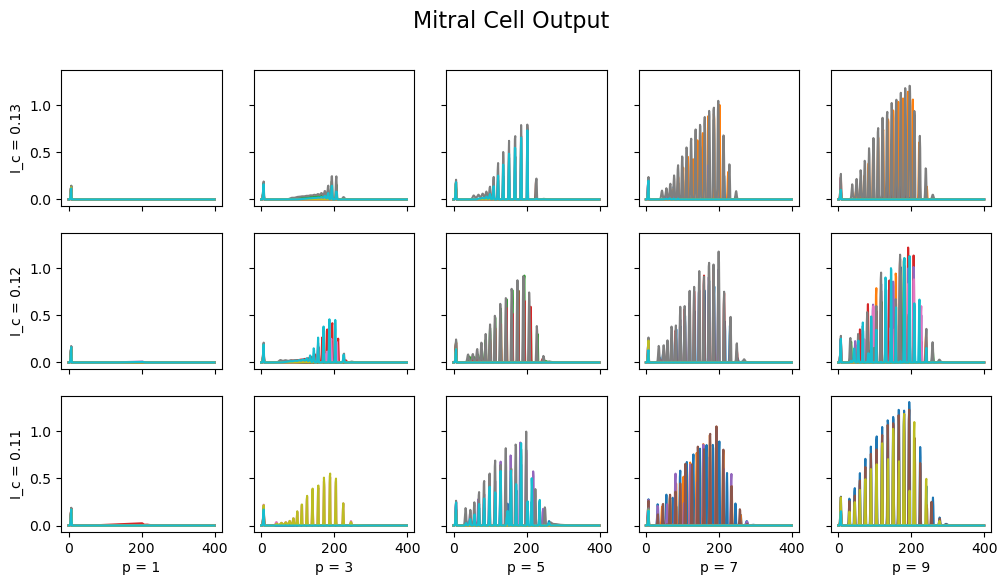

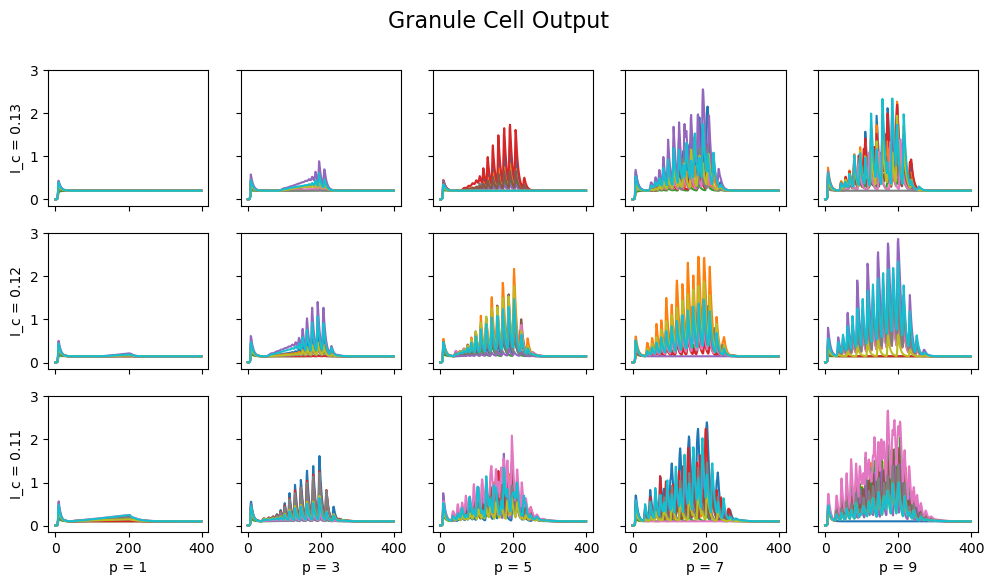

In [33]:
rows = 3
cols = 5
fig1, axs1 = plt.subplots(figsize=(12, 6), nrows=rows, ncols=cols, sharex=True, sharey=True)
fig2, axs2 = plt.subplots(figsize=(12, 6), nrows=rows, ncols=cols, sharex=True, sharey=True)
for i in range(rows):
    for j in range(cols):
        # print(f"cell : {i, j}, p = {2 * j + 1}, I_c = {0.13 - 0.01*i}")
        axs1[i, j].plot(generate_xy(2 * j + 1, 0.13 - 0.01*i)[0])
        axs2[i, j].plot(generate_xy(2 * j + 1, 0.13 - 0.01*i)[1])

for i, ax in enumerate(axs1.flat):
    ax.set(xlabel=f'p = {2*(i%5) + 1}', ylabel=f'I_c = {round(0.13 - (int(i/5))/100, 2)}')
for i, ax in enumerate(axs2.flat):
        ax.set(xlabel=f'p = {2*(i%5) + 1}', ylabel=f'I_c = {round(0.13 - (int(i/5))/100, 2)}')

for ax in axs1.flat:
    ax.label_outer()
for ax in axs2.flat:
    ax.label_outer()
fig1.suptitle('Mitral Cell Output', fontsize=16)
fig2.suptitle('Granule Cell Output', fontsize=16)

# df = pd.DataFrame(X_out, columns = [f"Cell {i+1}" for i in range(N)], index=[i for i in range(cycles * t_total)])
# df.to_csv('out_li.csv')


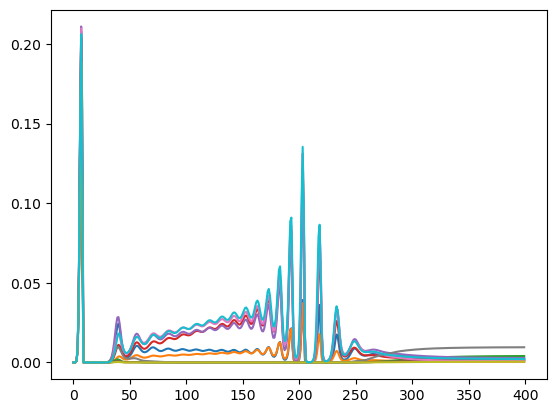

In [42]:
plt.plot(generate_xy(1, 0.1)[0])


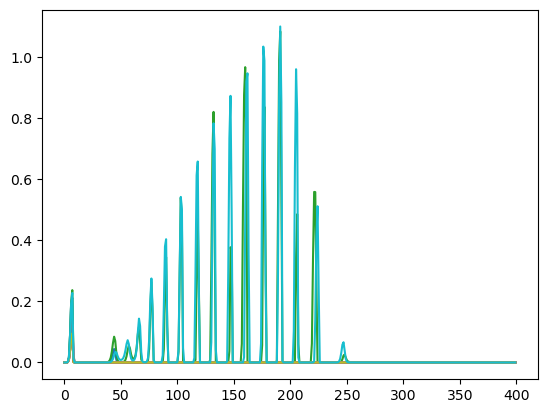

In [20]:
plt.plot(generate_xy(8, 0.13)[0])